1. Datenübersicht 

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



In [26]:
# Lebenserwartung gesamt
url = "https://ourworldindata.org/grapher/life-expectancy.csv"

# Daten laden
df = pd.read_csv(url)

# Erste Zeilen anzeigen
print(df.head())
print(df.columns)


        Entity Code  Year  Period life expectancy at birth
0  Afghanistan  AFG  1950                          28.1563
1  Afghanistan  AFG  1951                          28.5836
2  Afghanistan  AFG  1952                          29.0138
3  Afghanistan  AFG  1953                          29.4521
4  Afghanistan  AFG  1954                          29.6975
Index(['Entity', 'Code', 'Year', 'Period life expectancy at birth'], dtype='object')


2. Daten vorbereiten

In [27]:
df[df['Year'] >= 2000]

,Entity,Code,Year,Period life expectancy at birth
50,Afghanistan,AFG,2000,55.0047
51,Afghanistan,AFG,2001,55.5113
52,Afghanistan,AFG,2002,56.2251
53,Afghanistan,AFG,2003,57.1713
54,Afghanistan,AFG,2004,57.8098
...,...,...,...,...
21560,Zimbabwe,ZWE,2019,61.0603
21561,Zimbabwe,ZWE,2020,61.5300
21562,Zimbabwe,ZWE,2021,60.1347
21563,Zimbabwe,ZWE,2022,62.3601


In [29]:
import pandas as pd

# OWID Grapher CSV für Lebenserwartung
url = "https://ourworldindata.org/grapher/life-expectancy.csv"
df = pd.read_csv(url)

# Erste Zeilen
print(df.head())


        Entity Code  Year  Period life expectancy at birth
0  Afghanistan  AFG  1950                          28.1563
1  Afghanistan  AFG  1951                          28.5836
2  Afghanistan  AFG  1952                          29.0138
3  Afghanistan  AFG  1953                          29.4521
4  Afghanistan  AFG  1954                          29.6975


In [31]:
# Spaltennamen
print("Spalten:", df.columns.tolist())

# Datentypen
print(df.dtypes)

# Anzahl Länder und Jahre
print("Anzahl Länder:", df["Entity"].nunique())
print("Zeitraum:", df["Year"].min(), "-", df["Year"].max())


Spalten: ['Entity', 'Code', 'Year', 'Period life expectancy at birth']
Entity                              object
Code                                object
Year                                 int64
Period life expectancy at birth    float64
dtype: object
Anzahl Länder: 265
Zeitraum: 1543 - 2023


In [34]:
# Übersicht der Datentypen
print(df.dtypes)

# Interpretation:
# - Entity: object (string, kategorial)
# - Code: object (string, ISO-Code)
# - Year: int64 (diskret, aber geordnet)
# - Life expectancy: float64 (kontinuierlich)


Entity                              object
Code                                object
Year                                 int64
Period life expectancy at birth    float64
dtype: object


In [39]:
# Beispiel: Pivot für Geschlechtervergleich (Wide-Format)
# Wir laden die einzelnen Grapher-CSVs und benennen die erste numerische Wertespalte um.
def load_and_rename(url, new_name):
    import urllib.error

    # Versuche mehrere URL-Varianten, falls 404 auftritt
    candidate_urls = [url]
    if not url.endswith(".csv"):
        candidate_urls.append(url + ".csv")
    candidate_urls.append(url.replace("-rate", "").replace("_rate", "") + ".csv")
    candidate_urls.append(url.replace("-rate", "mortality") + ".csv")
    # deduplizieren und filtern
    seen = set()
    candidate_urls = [u for u in candidate_urls if u and (u not in seen and not seen.add(u))]

    tmp = None
    last_url = None
    for u in candidate_urls:
        try:
            tmp = pd.read_csv(u)
            last_url = u
            break
        except urllib.error.HTTPError as e:
            print(f"Warning: HTTPError for {u}: {e}. Trying next candidate...")
            continue
        except Exception as e:
            print(f"Warning: could not read {u}: {e}. Trying next candidate...")
            continue

    if tmp is None:
        # Keinen Datensatz laden können -> leeres DataFrame mit erwarteten Spalten zurückgeben
        print(f"Warning: Could not load data from any candidate URL for {url}. Returning empty DataFrame with expected columns.")
        return pd.DataFrame(columns=[c for c in ["Entity", "Code", "Year", new_name]])

    # finde erste numerische Spalte außer Entity/Code/Year
    candidates = [c for c in tmp.columns if c not in ["Entity", "Code", "Year"]]
    val_col = None
    for c in candidates:
        if pd.api.types.is_numeric_dtype(tmp[c]):
            val_col = c
            break
    if val_col is None:
        # Versuch, Spalten in numerisch zu konvertieren
        for c in candidates:
            tmp[c] = pd.to_numeric(tmp[c], errors="coerce")
            if tmp[c].notna().any():
                val_col = c
                break

    if val_col is None:
        print(f"Warning: No numeric value column found in data from {last_url or url}. Returning empty DataFrame with expected columns.")
        return pd.DataFrame(columns=[c for c in ["Entity", "Code", "Year", new_name]])

    tmp = tmp.rename(columns={val_col: new_name})
    keep = [c for c in ["Entity", "Code", "Year", new_name] if c in tmp.columns]
    return tmp[keep]

# URLs sind in vorherigen Zellen definiert: url_le_total, url_le_female, url_le_male, url_u5
df_total = load_and_rename(url_le_total, "Lebenserwartung_Gesamt")
df_female = load_and_rename(url_le_female, "Lebenserwartung_Frauen")
df_male = load_and_rename(url_le_male, "Lebenserwartung_Maenner")
df_u5 = load_and_rename(url_u5, "Kindersterblichkeit")

# Zusammenführen (Wide-Format)
df = (df_total[["Entity", "Code", "Year", "Lebenserwartung_Gesamt"]]
      .merge(df_female[["Entity", "Year", "Lebenserwartung_Frauen"]], on=["Entity", "Year"], how="left")
      .merge(df_male[["Entity", "Year", "Lebenserwartung_Maenner"]], on=["Entity", "Year"], how="left")
      .merge(df_u5[["Entity", "Year", "Kindersterblichkeit"]], on=["Entity", "Year"], how="left"))

# Gap berechnen (sicherheitscheck bei fehlenden Spalten)
if "Lebenserwartung_Frauen" in df.columns and "Lebenserwartung_Maenner" in df.columns:
    df["Gap_Frauen_Maenner"] = df["Lebenserwartung_Frauen"] - df["Lebenserwartung_Maenner"]
else:
    df["Gap_Frauen_Maenner"] = pd.NA

print(df.head())


Empty DataFrame
Columns: [Entity, Code, Year, Lebenserwartung_Gesamt, Lebenserwartung_Frauen, Lebenserwartung_Maenner, Kindersterblichkeit, Gap_Frauen_Maenner]
Index: []


3. Statistik der Rohdaten

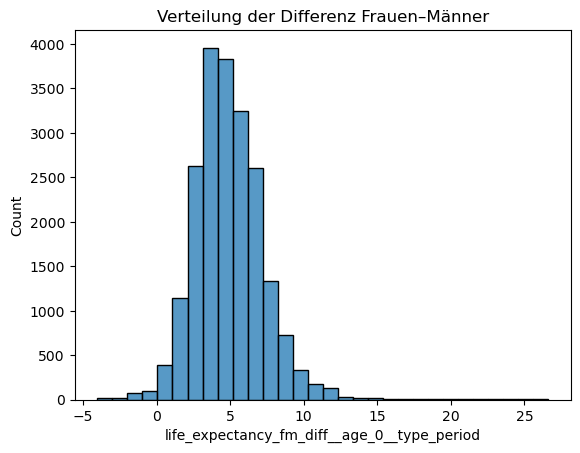

In [ ]:
# Histogramm der Differenzen
sns.histplot(df['life_expectancy_fm_diff__age_0__type_period'], bins=30)
plt.title("Verteilung der Differenz Frauen–Männer")
plt.show()




In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


4. Analyse Vorgehen
Fragestellung: Leben Frauen länger als Männer, und wie verändert sich die Differenz über Zeit?

Berechnungen:

Mittelwert der Differenz pro Dekade.

Trendanalyse pro Land.

Vergleich zwischen Regionen.

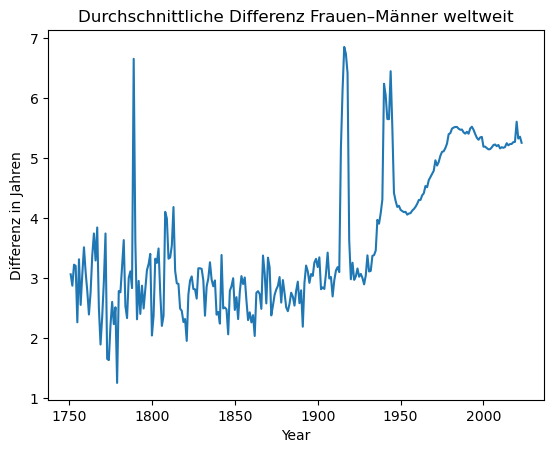

In [ ]:
trend = df.groupby("Year")["life_expectancy_fm_diff__age_0__type_period"].mean()
trend.plot()
plt.title("Durchschnittliche Differenz Frauen–Männer weltweit")
plt.ylabel("Differenz in Jahren")
plt.show()


C:\Users\matri\AppData\Local\Temp\ipykernel_16588\534043216.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="life_expectancy_fm_diff__age_0__type_period", y="Entity", data=top10, palette="viridis")


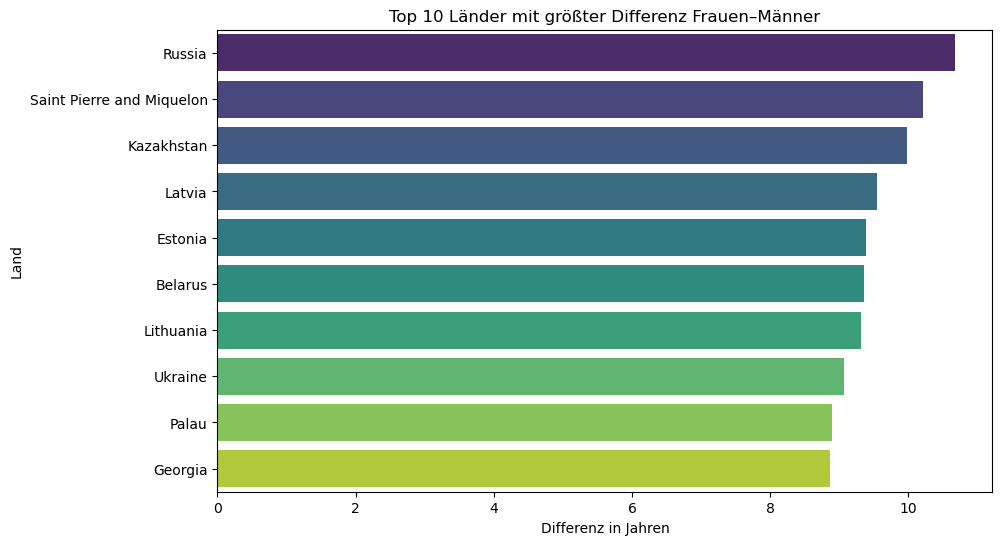

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mittelwert pro Land berechnen
country_mean = df.groupby("Entity")["life_expectancy_fm_diff__age_0__type_period"].mean().reset_index()

# Balkendiagramm (nur die Top 10 Länder mit größter Differenz)
top10 = country_mean.sort_values(by="life_expectancy_fm_diff__age_0__type_period", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x="life_expectancy_fm_diff__age_0__type_period", y="Entity", data=top10, palette="viridis")
plt.title("Top 10 Länder mit größter Differenz Frauen–Männer")
plt.xlabel("Differenz in Jahren")
plt.ylabel("Land")
plt.show()

